<a href="https://colab.research.google.com/github/gyhou/tennis_atp/blob/master/gh_tennis_atp_rankings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing ATP and WTA Pro Tennis Players Dataset

In [0]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

## Load, Clean and Merge Datasets

In [2]:
# merge all ranked ATP players
df_rank_80 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_rankings_80s.csv")
df_rank_90 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_rankings_90s.csv")
df_rank_00 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_rankings_00s.csv")
df_rank_10 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_rankings_10s.csv")
df_rank_19 = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_rankings_current.csv")


dfs_rank = [df_rank_80, df_rank_90, df_rank_00, 
            df_rank_10, df_rank_19]

df_rank = pd.concat(dfs_rank, axis=0, sort=False, join='outer')
# rename player and country columns, added name column
df_rank = df_rank.rename(columns={'player': 'player_id'})
print(df_rank.shape)
df_rank.sample(5)

(2771191, 4)


,ranking_date,rank,player,points
259300,19891120,89,101727,NaN
347297,19950313,283,102378,123.0
686477,20170320,1370,135146,3.0
492338,20150420,890,121957,16.0
177029,19880509,894,107444,NaN


In [4]:
# load players name df
df_players = pd.read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_players.csv")
# renaming columns and values
df_players = df_players.rename(columns={'country': 'country_id'})
# combine first and last name
df_players['name'] = df_players['name_first']+" "+df_players['name_list']
print(df_players.shape)
df_players.sample(5)

(54067, 7)


,player_id,name_first,name_list,hand,birthdate,country_id,name
33505,133521,Alex,Morilla,R,19961220.0,ESP,Alex Morilla
13445,113461,Jack,Agar,NaN,NaN,USA,Jack Agar
7598,107613,M,Castigliano,R,NaN,ITA,M Castigliano
27568,127584,Juan Pablo,Witt,U,19930728.0,ECU,Juan Pablo Witt
37548,137564,Lazar,Paripovic,U,19890811.0,SRB,Lazar Paripovic


In [8]:
# merge players name and id
atp_ranks = pd.merge(df_rank, df_players, how='inner', on='player_id')
# convert birthdate to integer first before calculating age
atp_ranks = atp_ranks.astype({"ranking_date": float}, errors='ignore')
atp_ranks['age'] = (atp_ranks['ranking_date']-atp_ranks['birthdate'])/10000
# set ranking year
atp_ranks['r_year'] = atp_ranks['ranking_date']//10000

print(atp_ranks.shape)
atp_ranks.sample(5)

(2771191, 12)


,ranking_date,rank,player_id,points,name_first,name_list,hand,birthdate,country_id,name,age,r_year
2221017,20081006.0,1650,103932,1.0,Mario,Eckardt,L,19820206.0,GER,Mario Eckardt,26.0800,2008.0
2536124,20130422.0,1924,122471,1.0,Danylo,Kalenichenko,U,19940202.0,UKR,Danylo Kalenichenko,19.0220,2013.0
1054955,19980302.0,218,103193,188.0,Peter,Wessels,R,19780507.0,NED,Peter Wessels,19.9795,1998.0
1041380,19980302.0,874,102889,10.0,Hee Sung,Chung,R,19761125.0,KOR,Hee Sung Chung,21.9177,1998.0
1932155,20080825.0,756,104522,21.0,Chris,Klingemann,U,19850324.0,CAN,Chris Klingemann,23.0501,2008.0


## Trim dataset to only top 100 ranked players

In [45]:
# top 100 players all time over 10 years old
atp_100 = atp_ranks[(atp_ranks['rank']<=100)&(atp_ranks['age']>=10)]
# remove duplicates since 1984
dfs_single_100 = [atp_100[atp_100['r_year']==year].drop_duplicates(
                 ['name'], keep='last').drop_duplicates(
                 ['rank'], keep='last') for year in range(1984,2020)]
atp_100 = pd.concat(dfs_single_100, axis=0, sort=False, join='outer')
# convert integer date to proper date format
atp_100['r_date'] = atp_100['ranking_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
print(atp_100.shape)
atp_100.sample(5)

(3597, 13)


,ranking_date,rank,player_id,points,name_first,name_list,hand,birthdate,country_id,name,age,r_year,r_date
1020805,20011231.0,80,103454,510.0,Nicolas,Massu,R,19791010.0,CHI,Nicolas Massu,22.0221,2001.0,2001-12-31
447445,19911230.0,41,101965,NaN,Wayne,Ferreira,R,19710915.0,RSA,Wayne Ferreira,20.0315,1991.0,1991-12-30
1832128,20131230.0,86,104714,612.0,Julian,Reister,R,19860402.0,GER,Julian Reister,27.0828,2013.0,2013-12-30
1653271,20091228.0,78,104999,590.0,Mischa,Zverev,L,19870822.0,GER,Mischa Zverev,22.0406,2009.0,2009-12-28
87482,19841224.0,94,100901,NaN,Paul,Annacone,R,19630320.0,USA,Paul Annacone,21.0904,1984.0,1984-12-24


In [46]:
# bin countries into region
atp_100['Region'] = atp_100['country_id'].replace({
    'ESP':'Europe','FRA':'Europe','GER':'Europe','CZE':'Europe','SWE':'Europe',
    'EST':'Europe','GRE':'Europe','SUI':'Europe','GBR':'Europe','SRB':'Europe',
    'CRO':'Europe','AUT':'Europe','SVK':'Europe','BUL':'Europe','UKR':'Europe',
    'BEL':'Europe','ROU':'Europe','LAT':'Europe','FIN':'Europe','POR':'Europe',
    'DEN':'Europe','POL':'Europe','SLO':'Europe','BLR':'Europe','LUX':'Europe',
    'HUN':'Europe','LTU':'Europe','BIH':'Europe','NOR':'Europe','YUG':'Europe',
    'MDA':'Europe','GEO':'Europe','MON':'Europe','NED':'Europe','ITA':'Europe',
    'KEN':'Africa','SEN':'Africa','RSA':'Africa','MAR':'Africa','ZIM':'Africa',
    'TUN':'Africa','NGR':'Africa',
    'BAH':'North America','CAN':'North America','MEX':'North America',
    'CRC':'North America','DOM':'North America','USA':'North America',
    'BOL':'South America','CHI':'South America','ECU':'South America', 
    'URU':'South America','PER':'South America','COL':'South America',
    'PAR':'South America','VEN':'South America','BRA':'South America',
    'ARG':'South America',
    'JPN':'Asia','THA':'Asia','KAZ':'Asia','IND':'Asia','TPE':'Asia',
    'KOR':'Asia','UZB':'Asia','PHI':'Asia','RUS':'Asia','TUR':'Asia',
    'CYP':'Asia','ISR':'Asia','ARM':'Asia',
    'AUS': 'Australia','NZL': 'Australia'
    })
atp_100.sample(5)

,ranking_date,rank,player_id,points,name_first,name_list,hand,birthdate,country_id,name,age,r_year,r_date,Region
1237833,20071231.0,60,103781,590.0,Jurgen,Melzer,L,19810522.0,AUT,Jurgen Melzer,26.0709,2007.0,2007-12-31,Europe
225005,19921228.0,58,101377,NaN,Christian,Bergstrom,R,19670719.0,SWE,Christian Bergstrom,25.0509,1992.0,1992-12-28,Europe
694901,20031229.0,85,102287,436.0,Albert,Portas,R,19731115.0,ESP,Albert Portas,30.0114,2003.0,2003-12-29,Europe
790504,19991227.0,15,102796,1244.0,Magnus,Norman,R,19760530.0,SWE,Magnus Norman,23.0697,1999.0,1999-12-27,Europe
1535232,20121231.0,28,104252,1215.0,Florian,Mayer,R,19831005.0,GER,Florian Mayer,29.0226,2012.0,2012-12-31,Europe


In [47]:
# create dataframe for average top 100 players' age
age_data = []
for year in range(1984,2020):
  df_year = atp_100[atp_100['r_year']==year]
  age_100 = df_year.age
  age_mean = age_100.mean()
  age_data.append([df_year.iloc[-1]['r_date'], age_mean])
  
atp_age_100 = pd.DataFrame(age_data,columns=['date','Average Age'])
atp_age_100.describe(include='all')

,date,Average Age
count,36,36.000000
unique,36,NaN
top,2017-12-25 00:00:00,NaN
freq,1,NaN
first,1984-12-17 00:00:00,NaN
last,2019-02-25 00:00:00,NaN
mean,NaN,25.286645
std,NaN,1.380746
min,NaN,23.344974
25%,NaN,24.336616


## Graph average age of top 100 ranked players

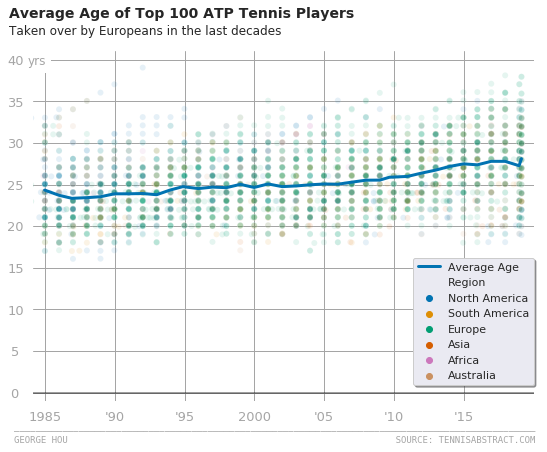

In [118]:
fig, ax = plt.subplots(figsize=(8,6))
# set plot style
plt.style.use('fivethirtyeight')
# despine outer frame
sns.set()
sns.despine(left=True, bottom=True)
# set background to white
plt.rcParams['figure.facecolor'] = 'white'
plt.grid(color='#A5A5A5')
ax.set(yticks=range(0, 50, 5), facecolor='white')
# Color palette
blue, = sns.color_palette("colorblind", 1)
# average age mean line
ax.plot(atp_age_100.date, atp_age_100['Average Age'], color=blue, lw=3)

# scatterplot of all 100 players' age
ax = sns.scatterplot(x="r_date", y="age", hue="Region", alpha=.1,
                     palette="colorblind", data=atp_100, legend='full')
# set x and y label
ax.set_xlabel('', fontsize=20, color='#A5A5A5')
ax.set_ylabel('', fontsize=20, color='#A5A5A5')
# modify y labels
ax.set_yticks([0, 5, 10, 15, 20,25,30,35,40])
ax.set_yticklabels(labels=['0 ','5 ','10','15','20','25','30','35','40'], 
                   fontsize=13, color='#A5A5A5')
# modify x labels
ax.set_xticks([pd.to_datetime('1985-1-1'), pd.to_datetime('1990-1-1'), 
               pd.to_datetime('1995-1-1'), pd.to_datetime('2000-1-1'), 
               pd.to_datetime('2005-1-1'), pd.to_datetime('2010-1-1'), 
               pd.to_datetime('2015-1-1')])
ax.set_xticklabels(labels=["1985","'90","'95","2000","'05","'10","'15"], 
                   fontsize=13, color='#A5A5A5')
# change size and color of tick labels, extend grid
plt.tick_params(axis='x',labelsize=13,labelcolor='#A5A5A5')
plt.tick_params(axis='y',labelsize=13,labelcolor='#A5A5A5')
# set x and y limits
ax.set(xlim=([pd.to_datetime('1984-2-25'), pd.to_datetime('2020-1-31')]), 
       ylim=(-1,41))
# bold y axis at 0
ax.axhline(y=0, color='black', linewidth=1.5, alpha=0.5)
# Text for Title
ax.text(x=pd.to_datetime('1982-6-1'), y=45, s="Average Age of Top 100 ATP Tennis Players", 
        fontsize=14, fontweight='bold');
# Text for Subtitle
ax.text(x=pd.to_datetime('1982-6-1'), y=43, s="Taken over by Europeans in the last decades", 
        fontsize=12);
# text for yrs next to 40
ax.text(x=pd.to_datetime('1983-10-1'), y=39.4, s="yrs", fontsize=12, color='#A5A5A5', 
        backgroundcolor = 'white')
# signature line at bottom
ax.text(x = pd.to_datetime('1982-10-1'), y = -4.5,
    s = '_________________________________________________________________________________________________',
    fontsize = 9, family='monospace', color = '#A5A5A5')
ax.text(x = pd.to_datetime('1982-10-1'), y = -6,
    s = 'GEORGE HOU                                                             SOURCE: TENNISABSTRACT.COM',
    fontsize = 9, family='monospace', color = '#A5A5A5')

# Put a legend to the right of the current axis
ax.legend(loc='lower right', bbox_to_anchor=(1.01, 0.03),
          fancybox=True, shadow=True)

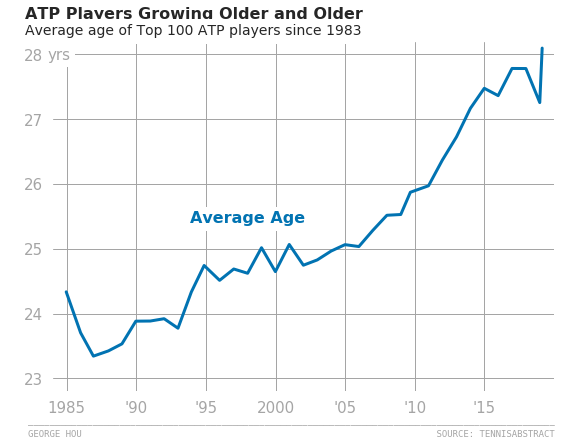

In [117]:
fig, ax = plt.subplots(figsize=(8,6))
# set plot style
plt.style.use('fivethirtyeight')

# despine outer frame
sns.set()
sns.despine(left=True, bottom=True)

# set background to white
plt.rcParams['figure.facecolor'] = 'white'
plt.grid(color='#A5A5A5')
ax.set(yticks=range(0, 50, 1), facecolor='white')

# Color palette
blue, = sns.color_palette("colorblind", 1)

# average age mean line
ax.plot(atp_age_100.date, atp_age_100['Average Age'], color=blue, lw=3)

# fill between upper std and lower bound std
# ax.fill_between(df_age_100.date, df_age_100.up_std, df_age_100.low_std, alpha=.2)

# set x and y label
ax.set_xlabel(' ',fontsize = 12,fontweight='semibold')
ax.set_ylabel(' ',fontsize = 12,fontweight='semibold')

# modify x labels
ax.set_xticks([pd.to_datetime('1985-1-1'), pd.to_datetime('1990-1-1'), 
               pd.to_datetime('1995-1-1'), pd.to_datetime('2000-1-1'), 
               pd.to_datetime('2005-1-1'), pd.to_datetime('2010-1-1'), 
               pd.to_datetime('2015-1-1')])
ax.set_xticklabels(labels=["1985","'90","'95","2000","'05","'10","'15"], 
                   fontsize=13, color='#A5A5A5')

# set x and y limits
ax.set_xlim([pd.to_datetime('1984-1-1'), pd.to_datetime('2019-12-31')])
ax.set_ylim([22.8, 28.2])

# change size and color of tick labels, extend grid
plt.tick_params(axis='x',labelsize=15,labelcolor='#A5A5A5', 
               color = '#A5A5A5')
plt.tick_params(axis = 'y', labelsize = 15, labelcolor = '#A5A5A5')

# Text for Title
ax.text(x=pd.to_datetime('1982-1-1'), y=28.55, s="ATP Players Growing Older and Older", 
        fontsize=16, fontweight='bold');

# Text for Subtitle
ax.text(x=pd.to_datetime('1982-1-1'), y=28.30,backgroundcolor = 'white',
        s="Average age of Top 100 ATP players since 1983", fontsize=14);

# text for yrs next to 40
ax.text(x=pd.to_datetime('1983-8-1'), y=27.925, s="yrs", fontsize=15, 
        color='#A5A5A5',backgroundcolor = 'white')

# text for average age
ax.text(x=pd.to_datetime('1993-10-30'), y=25.4, s="Average Age", fontsize=16, 
        color=blue, fontweight='semibold',backgroundcolor = 'white')

# signature line at bottom
ax.text(x =pd.to_datetime('1982-4-1'), y=22.3,
    s = '__________________________________________________________________________________________________',
    fontsize = 9, family='monospace', color = '#A5A5A5')
ax.text(x =pd.to_datetime('1982-4-1'), y=22.1,
    s = 'GEORGE HOU                                                                  SOURCE: TENNISABSTRACT',
    fontsize = 9, family='monospace', color = '#A5A5A5')

# bold y axis at 0
ax.axhline(y=0, color='black', linewidth=1.5, alpha=0.5)